#### Title: Classifying Red Wine Quality - Group 21

#### Introduction

"Vinho Verde" is a Portuguese wine which has three main variants, of which we will be considering red. In the kaggle dataset we are using from UCI Machine Learning, its quality is affected by 11 different physiochemical variables, such as acidity, chlorides, density, etc.. These 11 variables determine the quality of the wine, on a scale from 0-10. For the purpose of the classification task, we will be defining "good" quality wine as wine with a rating from 6-10, and anything below as "bad" quality. 

The question we will try to answer with our analysis is as follows: Which classification of vinho verde quality is a particular wine likely to be based on a range of physicochemical predictor variables? 

#### Preliminary exploratory data analysis

Below, we demonstrate the readability of our chosen dataset. For convenience in future data analysis, we remove the spaces between the column names with the make.names() function. From the tibble below, we can see that each row contains a single observation and each column is one variable, each cell containing a single value. Additionally, the column names are descriptive. Thus, this data is tidy.

In [4]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [5]:
red_wine <- read_csv("data/winequality-red.csv")|>
    mutate(quality = as_factor(quality))
colnames(red_wine) <- make.names(colnames(red_wine))
red_wine

Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5
6.0,0.310,0.47,3.6,0.067,18,42,0.99549,3.39,0.66,11.0,6


In [11]:
red_wine_split <- initial_split(red_wine, prop = 0.75, strata = quality)
red_wine_train <- training(red_wine_split)
red_wine_test <- testing(red_wine_split)
red_wine_train

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.4,0.70,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.70,0,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
7.4,0.25,0.29,2.2,0.054,19,49,0.99666,3.40,0.76,10.90,7
7.0,0.56,0.17,1.7,0.065,15,24,0.99514,3.44,0.68,10.55,7
6.7,0.32,0.44,2.4,0.061,24,34,0.99484,3.29,0.80,11.60,7


In [35]:
red_wine_quality_count <- red_wine_train |>
    group_by(quality) |>
    summarize(count = n())

missing_data <- red_wine_train |>
    summarize(NA_rows = sum(is.na(" ")))

red_wine_mean <- red_wine_train |>
    select(-quality) |>
    summarize(across(fixed.acidity:alcohol, mean))

red_wine_mean
red_wine_quality_count
missing_data

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.332387,0.5270159,0.2737396,2.555384,0.08784725,15.76252,46.87688,0.9967502,3.310943,0.6590735,10.43607


quality,count
<fct>,<int>
3,8
4,39
5,511
6,478
7,150
8,12


NA_rows
<int>
0


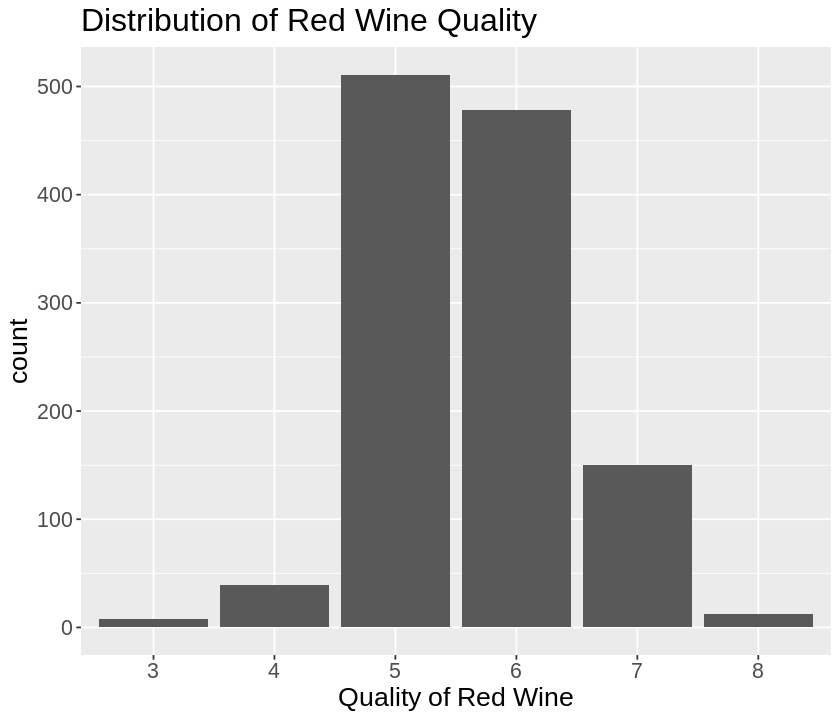

In [34]:
options(repr.plot.height = 6, repr.plot.width = 7)


red_wine_hist <- ggplot(red_wine_train, aes(x = quality)) +
  geom_bar(stat = "count") +
  labs(x = "Quality of Red Wine") + 
  theme(text = element_text(size = 16)) +
  ggtitle(paste0("Distribution of Red Wine Quality"))
    
red_wine_hist

#### Methods

Explain and descibe visual analysis.

#### Expected Outcomes & Significance

Expected findings, impacts, future questions.

:)
